# Import libraries

In [1]:
import os
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.cm as cm

import seaborn as sns

import json

from sklearn.feature_selection import mutual_info_classif

from collections import defaultdict

from tqdm import tqdm

In [2]:
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', None)

In [3]:
path_to_save = './../results/03c_features_analysis'

# Loading data

In [4]:
path_to_ftir_data= './../data/processed_data/ftir_features_long_list.csv'
path_to_features_description = './../data/processed_data/features_description.json'
path_to_samples_description = './../data/parsed_data/samples_description.csv'

## FTIR-features (*long-list*)

In [5]:
features_df = pd.read_csv(path_to_ftir_data, sep=';', index_col=0)

print(features_df.shape)
features_df.head(3)

(75, 565)


$\overline{I}_{3800\text{–}2500}$  $I_{3733}$  \
division_1_size_bulk                           0.396756    0.050403   
division_1_size_5                              0.430882    0.006416   
division_1_size_3                              0.407828    0.041028   

                      $\overline{I}_{3733 \pm 32}$  $I_{3383}$  \
division_1_size_bulk                      0.040558         1.0   
division_1_size_5                         0.005691         1.0   
division_1_size_3                         0.029982         1.0   

                      $\overline{I}_{3383 \pm 32}$  $I_{3297}$  \
division_1_size_bulk                      0.970571    0.945211   
division_1_size_5                         0.995591    0.908319   
division_1_size_3                         0.981950    0.901208   

                      $\overline{I}_{3297 \pm 32}$  $I_{2930}$  \
division_1_size_bulk                      0.938813    0.265624   
division_1_size_5                         0.905618    0.317784   
division_1_size_3                         0.898619    0.430246   

                      $\overline{I}_{2930 \pm 32}$  \
division_1_size_bulk                      0.266420   
division_1_size_5                         0.311382   
division_1_size_3                         0.405804   

                      $\overline{I}_{1800\text{–}900}$  \
division_1_size_bulk                          0.550025   
division_1_size_5                             0.494561   
division_1_size_3                             0.555338   

                      $\overline{I}_{1800\text{–}1500}$  $I_{1724}$  \
division_1_size_bulk                           0.550451    0.423149   
division_1_size_5                              0.532219    0.415541   
division_1_size_3                              0.562808    0.377704   

                      $\overline{I}_{1724 \pm 32}$  $I_{1641}$  \
division_1_size_bulk                      0.417009         1.0   
division_1_size_5                         0.409133         1.0   
division_1_size_3                         0.381130         1.0   

                      $\overline{I}_{1641 \pm 32}$  $I_{1596}$  \
division_1_size_bulk                      0.877687    0.873005   
division_1_size_5                         0.883698    0.856910   
division_1_size_3                         0.893990    0.903661   

                      $\overline{I}_{1596 \pm 32}$  $I_{1544}$  \
division_1_size_bulk                      0.845403    0.431357   
division_1_size_5                         0.827012    0.386789   
division_1_size_3                         0.882435    0.518637   

                      $\overline{I}_{1544 \pm 32}$  \
division_1_size_bulk                      0.460425   
division_1_size_5                         0.416980   
division_1_size_3                         0.539162   

                      $\overline{I}_{1500\text{–}1300}$  $I_{1430}$  \
division_1_size_bulk                           0.633387    0.677517   
division_1_size_5                              0.568436    0.621224   
division_1_size_3                              0.577782    0.648574   

                      $\overline{I}_{1430 \pm 32}$  $I_{1391}$  \
division_1_size_bulk                      0.661219    0.815626   
division_1_size_5                         0.605414    0.739353   
division_1_size_3                         0.631076    0.744396   

                      $\overline{I}_{1391 \pm 32}$  \
division_1_size_bulk                      0.785468   
division_1_size_5                         0.712254   
division_1_size_3                         0.716405   

                      $\overline{I}_{1300\text{–}900}$  ...  \
division_1_size_bulk                          0.508124  ...   
division_1_size_5                             0.429493  ...   
division_1_size_3                             0.538545  ...   

                      $\frac{I_{1067}}{\overline{I}_{876 \pm 32}}$  \
division_1_size_bulk                                      9.278031   
division_1_size_5                  

## Features description

In [6]:
with open(path_to_features_description, 'r', encoding='utf-8') as f:
    features_description = json.load(f)

## Samples description

In [7]:
samples_description = pd.read_csv(f'{path_to_samples_description}', sep=';', index_col=0)

print(samples_description.shape)
samples_description.head(3)

(75, 6)


Row_ID  Division  Size Fraction_hue  \
division_1_size_bulk       1         1  bulk        $> 0$   
division_1_size_5          2         1     5        $< 5$   
division_1_size_3          3         1     3        $< 3$   

                     Fraction_grouped_hue  Class  
division_1_size_bulk              $d > 5$      2  
division_1_size_5          $2 < d \leq 5$      1  
division_1_size_3          $2 < d \leq 5$      1

# Data wrangling

## Base parameters

In [8]:
hue = samples_description['Fraction_grouped_hue'].tolist()
hue_order = sorted(set(hue))

target = samples_description['Class'].tolist()

In [9]:
type_color_dict = {
    '$0< d \leq 2$': '#2166AC',
    '$2 < d \leq 5$': '#67A9CF',
    '$d > 5$': '#B2182B'
}

In [10]:
groups = list(type_color_dict.keys())

In [11]:
feature_types = [
    'base_features_peaks_3800_2500',
    'base_features_intervals_3800_2500',
    'base_features_peaks_1900_800',
    'base_features_intervals_1900_800',
    'engineered_features_peaks_3800_2500',
    'engineered_features_intervals_3800_2500',
    'engineered_features_peaks_1900_800',
    'engineered_features_intervals_1900_800'
]

In [12]:
sns.set_theme()

# Features analysis

## Mutual information

In [13]:
PLOT_STYLE = {
    'TITLE_FONT_SIZE': 18,
    'TITLE_FONTSTYLE': 'normal',
    'X_LABEL_FONT_SIZE': 16,
    'Y_LABEL_FONT_SIZE': 16,
    'X_TICK_LABEL_FONT_SIZE': 14,
    'Y_TICK_LABEL_FONT_SIZE': 16,
    'X_LABELPAD': 10,
    'Y_LABELPAD': 10,
    'X_NBINS': 7
}

TITLE_MAP = {
    'peaks_3800_2500': 'Точечные | 3800–2500 см$^{-1}$',
    'intervals_3800_2500': 'Интегральные | 3800–2500 см$^{-1}$',
    'peaks_1900_800': 'Точечные | 1900–800 см$^{-1}$',
    'intervals_1900_800': 'Интегральные | 1900–800 см$^{-1}$'
}

COLORS = {
    'base': 'RoyalBlue',
    'engineered': 'SeaGreen'
}

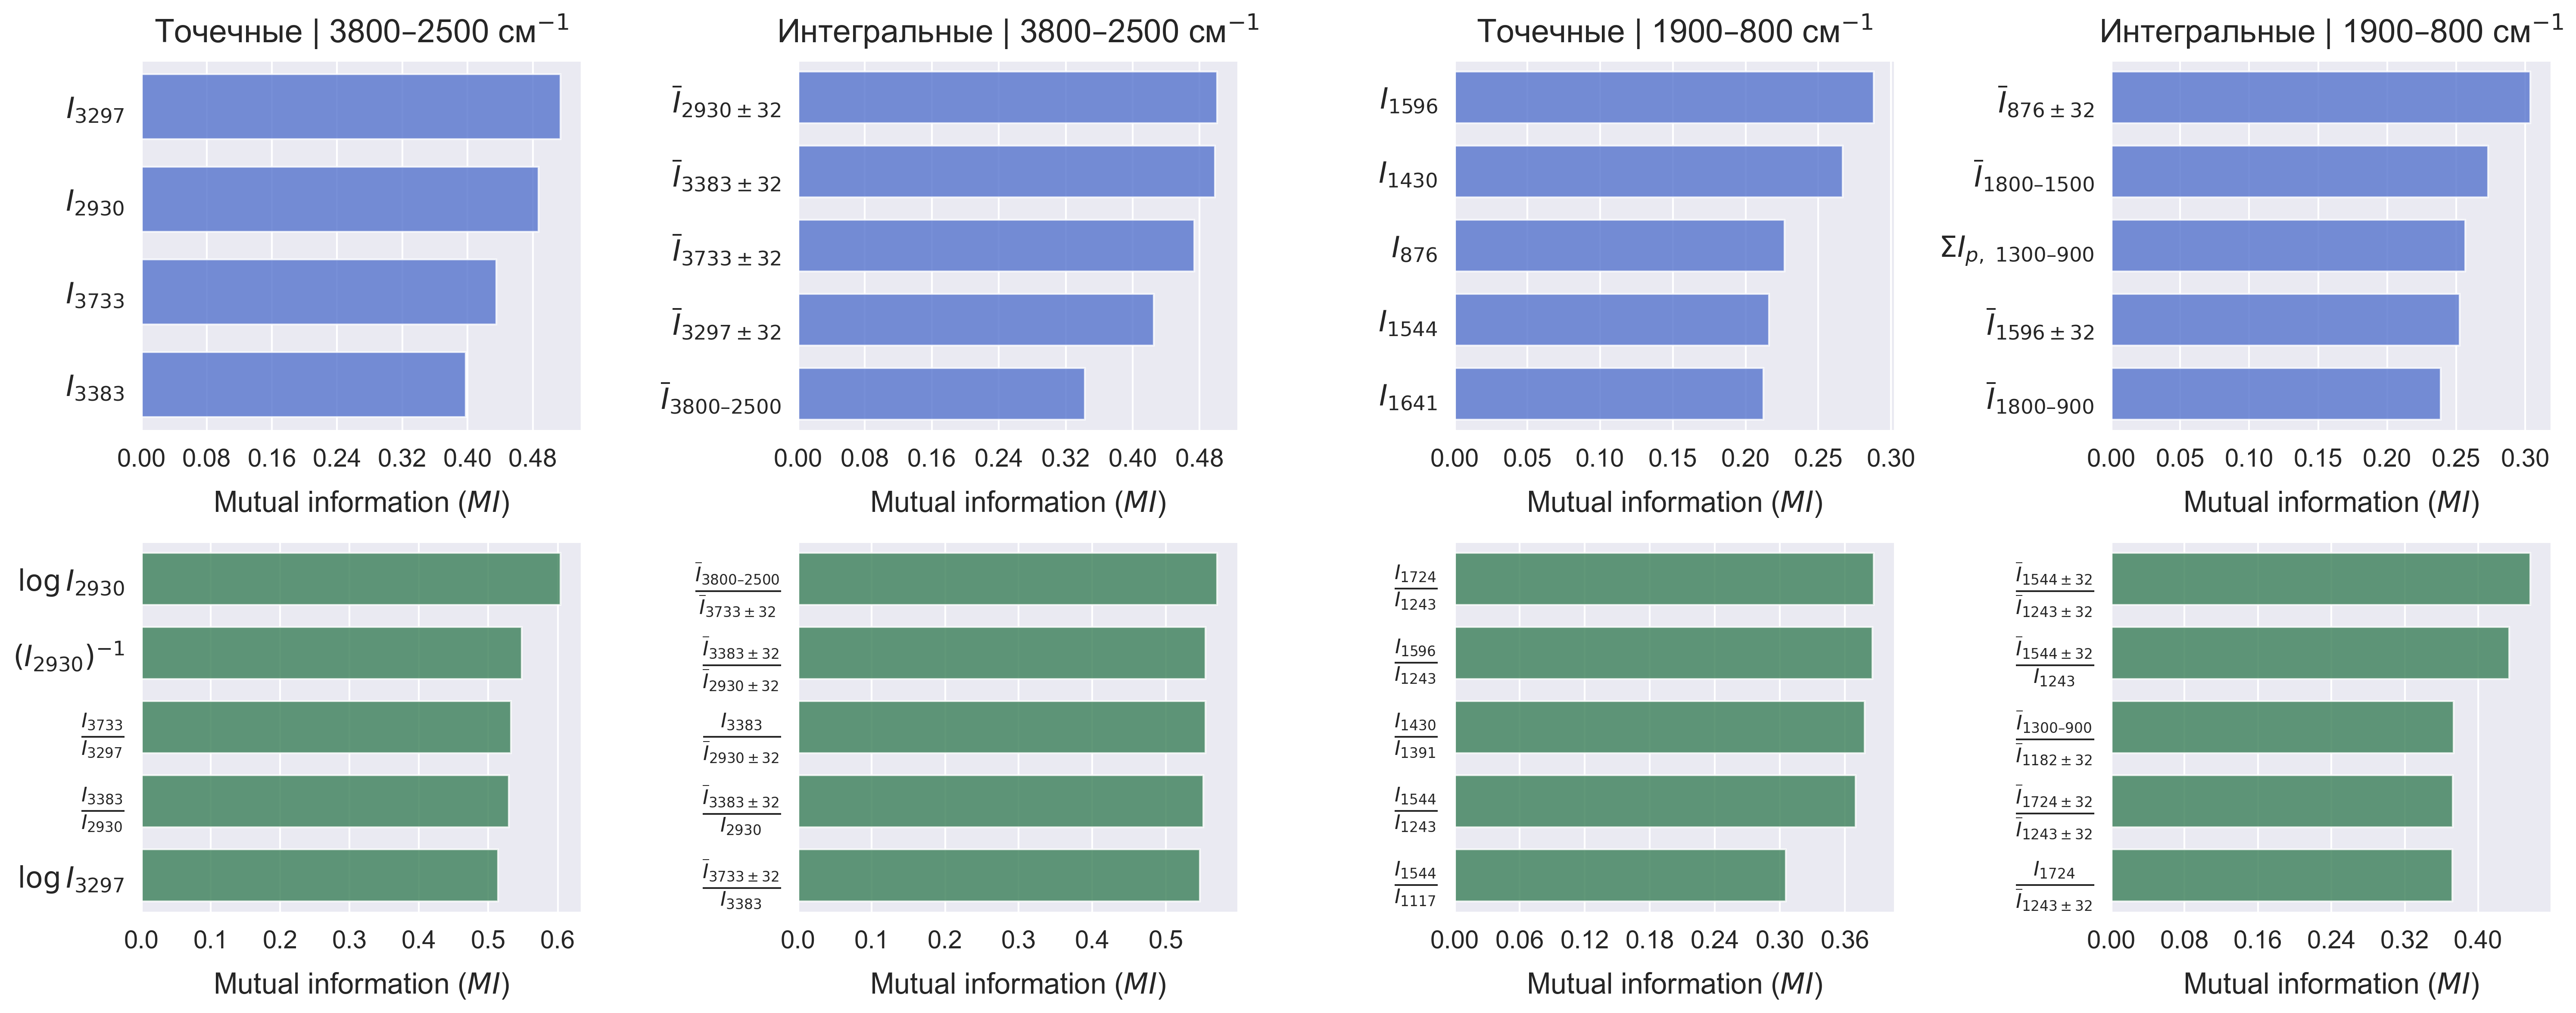

In [14]:
nrows = 2
ncols = 4

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 5, nrows * 4), dpi=300)
axes = axes.flat

for i, feature_type in enumerate(feature_types):
    X_subset = features_df[features_description[feature_type]]
    y_subset = target

    mi = mutual_info_classif(X_subset, y_subset, discrete_features='auto', random_state=42)
    
    result_df = pd.DataFrame({
        'Feature': X_subset.columns,
        'Mutual_Info': mi
    })
    result_df = result_df.sort_values(by='Mutual_Info', ascending=False).head(5)

    ax = axes[i]
    
    kind = 'engineered' if 'engineered' in feature_type else 'base'
    plot_color = COLORS[kind]

    sns.barplot(
        data=result_df,
        x='Mutual_Info',
        y='Feature',
        ax=ax,
        color=plot_color,
        width=0.7,
        alpha=0.8
    )

    if i < 4:
        key = '_'.join(feature_type.split('_')[2:])
        ax.set_title(TITLE_MAP[key], fontsize=PLOT_STYLE['TITLE_FONT_SIZE'], fontstyle=PLOT_STYLE['TITLE_FONTSTYLE'], pad=10)
        ax.set_xlabel('')
    
    ax.set_xlabel('Mutual information ($MI$)', fontsize=PLOT_STYLE['X_LABEL_FONT_SIZE'], labelpad=PLOT_STYLE['X_LABELPAD'])

    ax.set_ylabel('', fontsize=PLOT_STYLE['Y_LABEL_FONT_SIZE'], labelpad=PLOT_STYLE['Y_LABELPAD'])
    
    ax.tick_params(axis='x', labelsize=PLOT_STYLE['X_TICK_LABEL_FONT_SIZE'])
    ax.tick_params(axis='y', labelsize=PLOT_STYLE['Y_TICK_LABEL_FONT_SIZE'])
    
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=PLOT_STYLE['X_NBINS']))

plt.tight_layout()

plt.savefig(f'{path_to_save}/mutual_info_barplots.png', dpi=600)

plt.show()

## Visualization (BoxPlot & ViolinPlot)

In [15]:
base_feature_types = [
    'base_features_peaks_3800_2500',
    'base_features_intervals_3800_2500',
    'base_features_peaks_1900_800',
    'base_features_intervals_1900_800'
]

engineered_feature_types = [
    'engineered_features_peaks_3800_2500',
    'engineered_features_intervals_3800_2500',
    'engineered_features_peaks_1900_800',
    'engineered_features_intervals_1900_800'
]

### Function for sorting by *MS*

In [16]:
def get_ranked_features_by_mutual_info(features_df, target, features_description, feature_types):
    results_lst = []
    
    for feature_type in feature_types:
        X = features_df[features_description[feature_type]]
        mi = mutual_info_classif(X, target, discrete_features='auto', random_state=42)
        
        data = pd.DataFrame({
            'Feature': X.columns,
            'Mutual_Info': mi,
            'Feature_Type': feature_type
        })
        data = data.sort_values('Mutual_Info', ascending=False).reset_index(drop=True)
        
        results_lst.append(data)

    result_data = pd.concat(results_lst, ignore_index=True)
    return result_data

### *Base* features

#### Ranking features

In [17]:
ranked_data = get_ranked_features_by_mutual_info(
    features_df=features_df,
    target=target,
    features_description=features_description,
    feature_types=base_feature_types
)

print(ranked_data.shape)
ranked_data.head(3)

(40, 3)


Feature  Mutual_Info                   Feature_Type
0  $I_{3297}$     0.514088  base_features_peaks_3800_2500
1  $I_{2930}$     0.487163  base_features_peaks_3800_2500
2  $I_{3733}$     0.435482  base_features_peaks_3800_2500

In [18]:
top_n = 3

top_features_df = ranked_data.groupby('Feature_Type').head(top_n)

print(top_features_df.shape)
top_features_df.head(3)

(12, 3)


Feature  Mutual_Info                   Feature_Type
0  $I_{3297}$     0.514088  base_features_peaks_3800_2500
1  $I_{2930}$     0.487163  base_features_peaks_3800_2500
2  $I_{3733}$     0.435482  base_features_peaks_3800_2500

In [19]:
top_features = top_features_df['Feature']

#### Data preparation

In [20]:
df_vis = features_df[top_features].copy()
df_vis['target'] = target
df_vis['hue'] = hue

print(df_vis.shape)
df_vis.head(3)

(75, 14)


$I_{3297}$  $I_{2930}$  $I_{3733}$  \
division_1_size_bulk    0.945211    0.265624    0.050403   
division_1_size_5       0.908319    0.317784    0.006416   
division_1_size_3       0.901208    0.430246    0.041028   

                      $\overline{I}_{2930 \pm 32}$  \
division_1_size_bulk                      0.266420   
division_1_size_5                         0.311382   
division_1_size_3                         0.405804   

                      $\overline{I}_{3383 \pm 32}$  \
division_1_size_bulk                      0.970571   
division_1_size_5                         0.995591   
division_1_size_3                         0.981950   

                      $\overline{I}_{3733 \pm 32}$  $I_{1596}$  $I_{1430}$  \
division_1_size_bulk                      0.040558    0.873005    0.677517   
division_1_size_5                         0.005691    0.856910    0.621224   
division_1_size_3                         0.029982    0.903661    0.648574   

                      $I_{876}$  $\overline{I}_{876 \pm 32}$  \
division_1_size_bulk   0.078995                     0.079059   
division_1_size_5      0.077024                     0.079152   
division_1_size_3      0.138402                     0.140829   

                      $\overline{I}_{1800\text{–}1500}$  \
division_1_size_bulk                           0.550451   
division_1_size_5                              0.532219   
division_1_size_3                              0.562808   

                      $\Sigma I_{p,\ 1300\text{–}900}$  target             hue  
division_1_size_bulk                          2.409853       2         $d > 5$  
division_1_size_5                             2.155934       1  $2 < d \leq 5$  
division_1_size_3                             2.669431       1  $2 < d \leq 5$

In [21]:
feature_type_by_feature = dict(zip(ranked_data['Feature'], ranked_data['Feature_Type']))

grouped_features = defaultdict(list)

for feature in df_vis.columns:
    if feature in ['target', 'hue']:
        continue
    
    feature_type = feature_type_by_feature[feature]
    grouped_features[feature_type].append(feature)

#### Box plot

In [22]:
PLOT_STYLE = {
    'TITLE_FONT_SIZE': 16,
    'TITLE_FONTSTYLE': 'italic',
    'X_LABEL_FONT_SIZE': 16,
    'Y_LABEL_FONT_SIZE': 18,
    'X_TICK_LABEL_FONT_SIZE': 14,
    'Y_TICK_LABEL_FONT_SIZE': 14,
    'X_LABELPAD': 10,
    'Y_LABELPAD': 10,
    'X_NBINS': 10,
    'BOX_WIDTH': 0.6,
    'STRIP_ALPHA': 0.7,
    'STRIP_SIZE': 8,
    'STRIP_LINEWIDTH': 0.5,
    'STRIP_DODGE': True
}

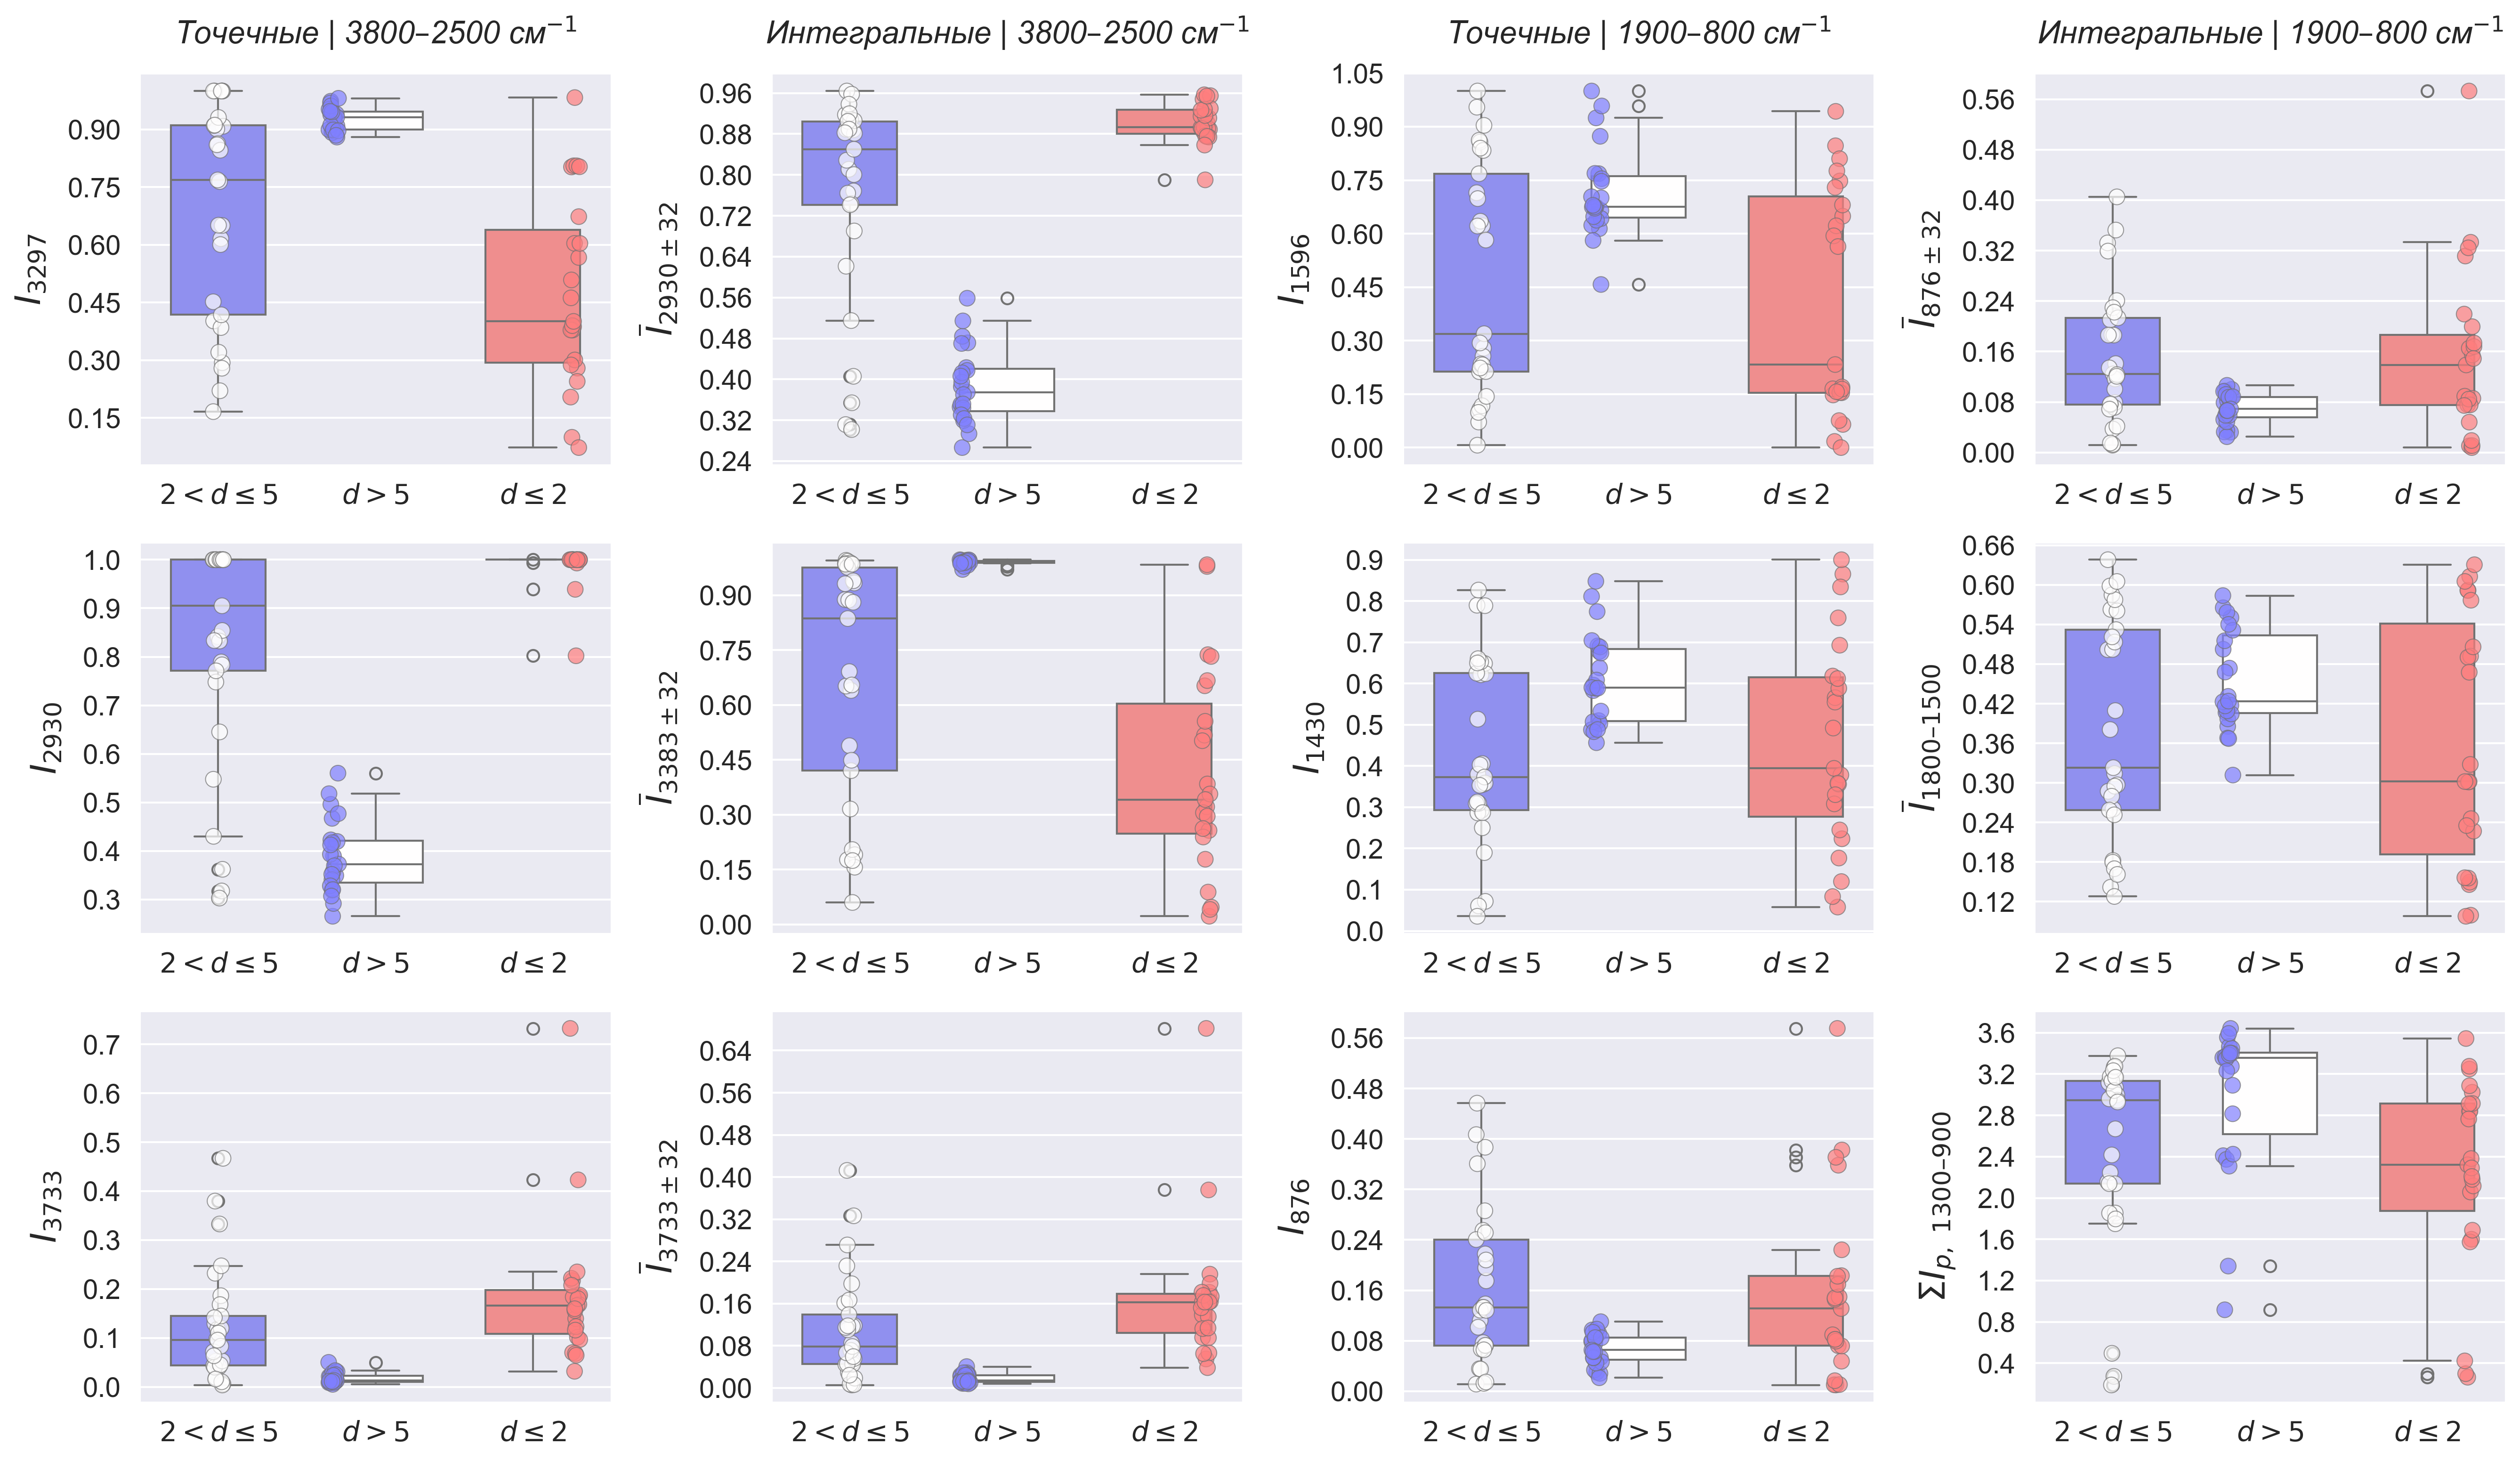

In [23]:
ncols = len(grouped_features)
nrows = 3

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4.5, nrows * 3.5), dpi=300)
axes = axes.T.flatten()

for col_idx, (feature_type, features) in enumerate(grouped_features.items()):
    for row_idx, feature in enumerate(features):
        ax = axes[col_idx * 3 + row_idx]

        sns.boxplot(
            data=df_vis,
            x='hue',
            y=feature,
            palette='bwr',
            width=PLOT_STYLE['BOX_WIDTH'],
            order=hue_order,
            ax=ax
        )

        sns.stripplot(
            data=df_vis,
            x='hue',
            y=feature,
            hue='hue',
            palette='bwr',
            alpha=PLOT_STYLE['STRIP_ALPHA'],
            size=PLOT_STYLE['STRIP_SIZE'],
            linewidth=PLOT_STYLE['STRIP_LINEWIDTH'],
            dodge=PLOT_STYLE['STRIP_DODGE'],
            ax=ax,
            legend=False
        )

        if row_idx == 0:
            key = '_'.join(feature_type.split('_')[2:])
            title = f'{TITLE_MAP.get(key, feature_type)}'
            ax.set_title(title, fontsize=PLOT_STYLE['TITLE_FONT_SIZE'], fontstyle=PLOT_STYLE['TITLE_FONTSTYLE'], pad=15)

        ax.set_xlabel('')
        ax.set_ylabel(feature, fontsize=PLOT_STYLE['Y_LABEL_FONT_SIZE'], labelpad=PLOT_STYLE['Y_LABELPAD'])

        ax.tick_params(axis='x', labelsize=PLOT_STYLE['X_TICK_LABEL_FONT_SIZE'])
        ax.tick_params(axis='y', labelsize=PLOT_STYLE['Y_TICK_LABEL_FONT_SIZE'])

        ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=PLOT_STYLE['X_NBINS']))

plt.tight_layout()

plt.savefig(f'{path_to_save}/boxplot_base_features.png', dpi=600)

plt.show()

#### Violin plot

In [24]:
PLOT_STYLE = {
    'TITLE_FONT_SIZE': 16,
    'TITLE_FONTSTYLE': 'italic',
    'X_LABEL_FONT_SIZE': 16,
    'Y_LABEL_FONT_SIZE': 18,
    'X_TICK_LABEL_FONT_SIZE': 14,
    'Y_TICK_LABEL_FONT_SIZE': 14,
    'X_LABELPAD': 10,
    'Y_LABELPAD': 10,
    'X_NBINS': 10,
    'VIOLIN_INNER': 'box',     # 'box', 'quartile', 'point', None
    'VIOLIN_CUT': 0,
    'VIOLIN_LINEWIDTH': 1,
    'PALETTE': 'bwr',
}


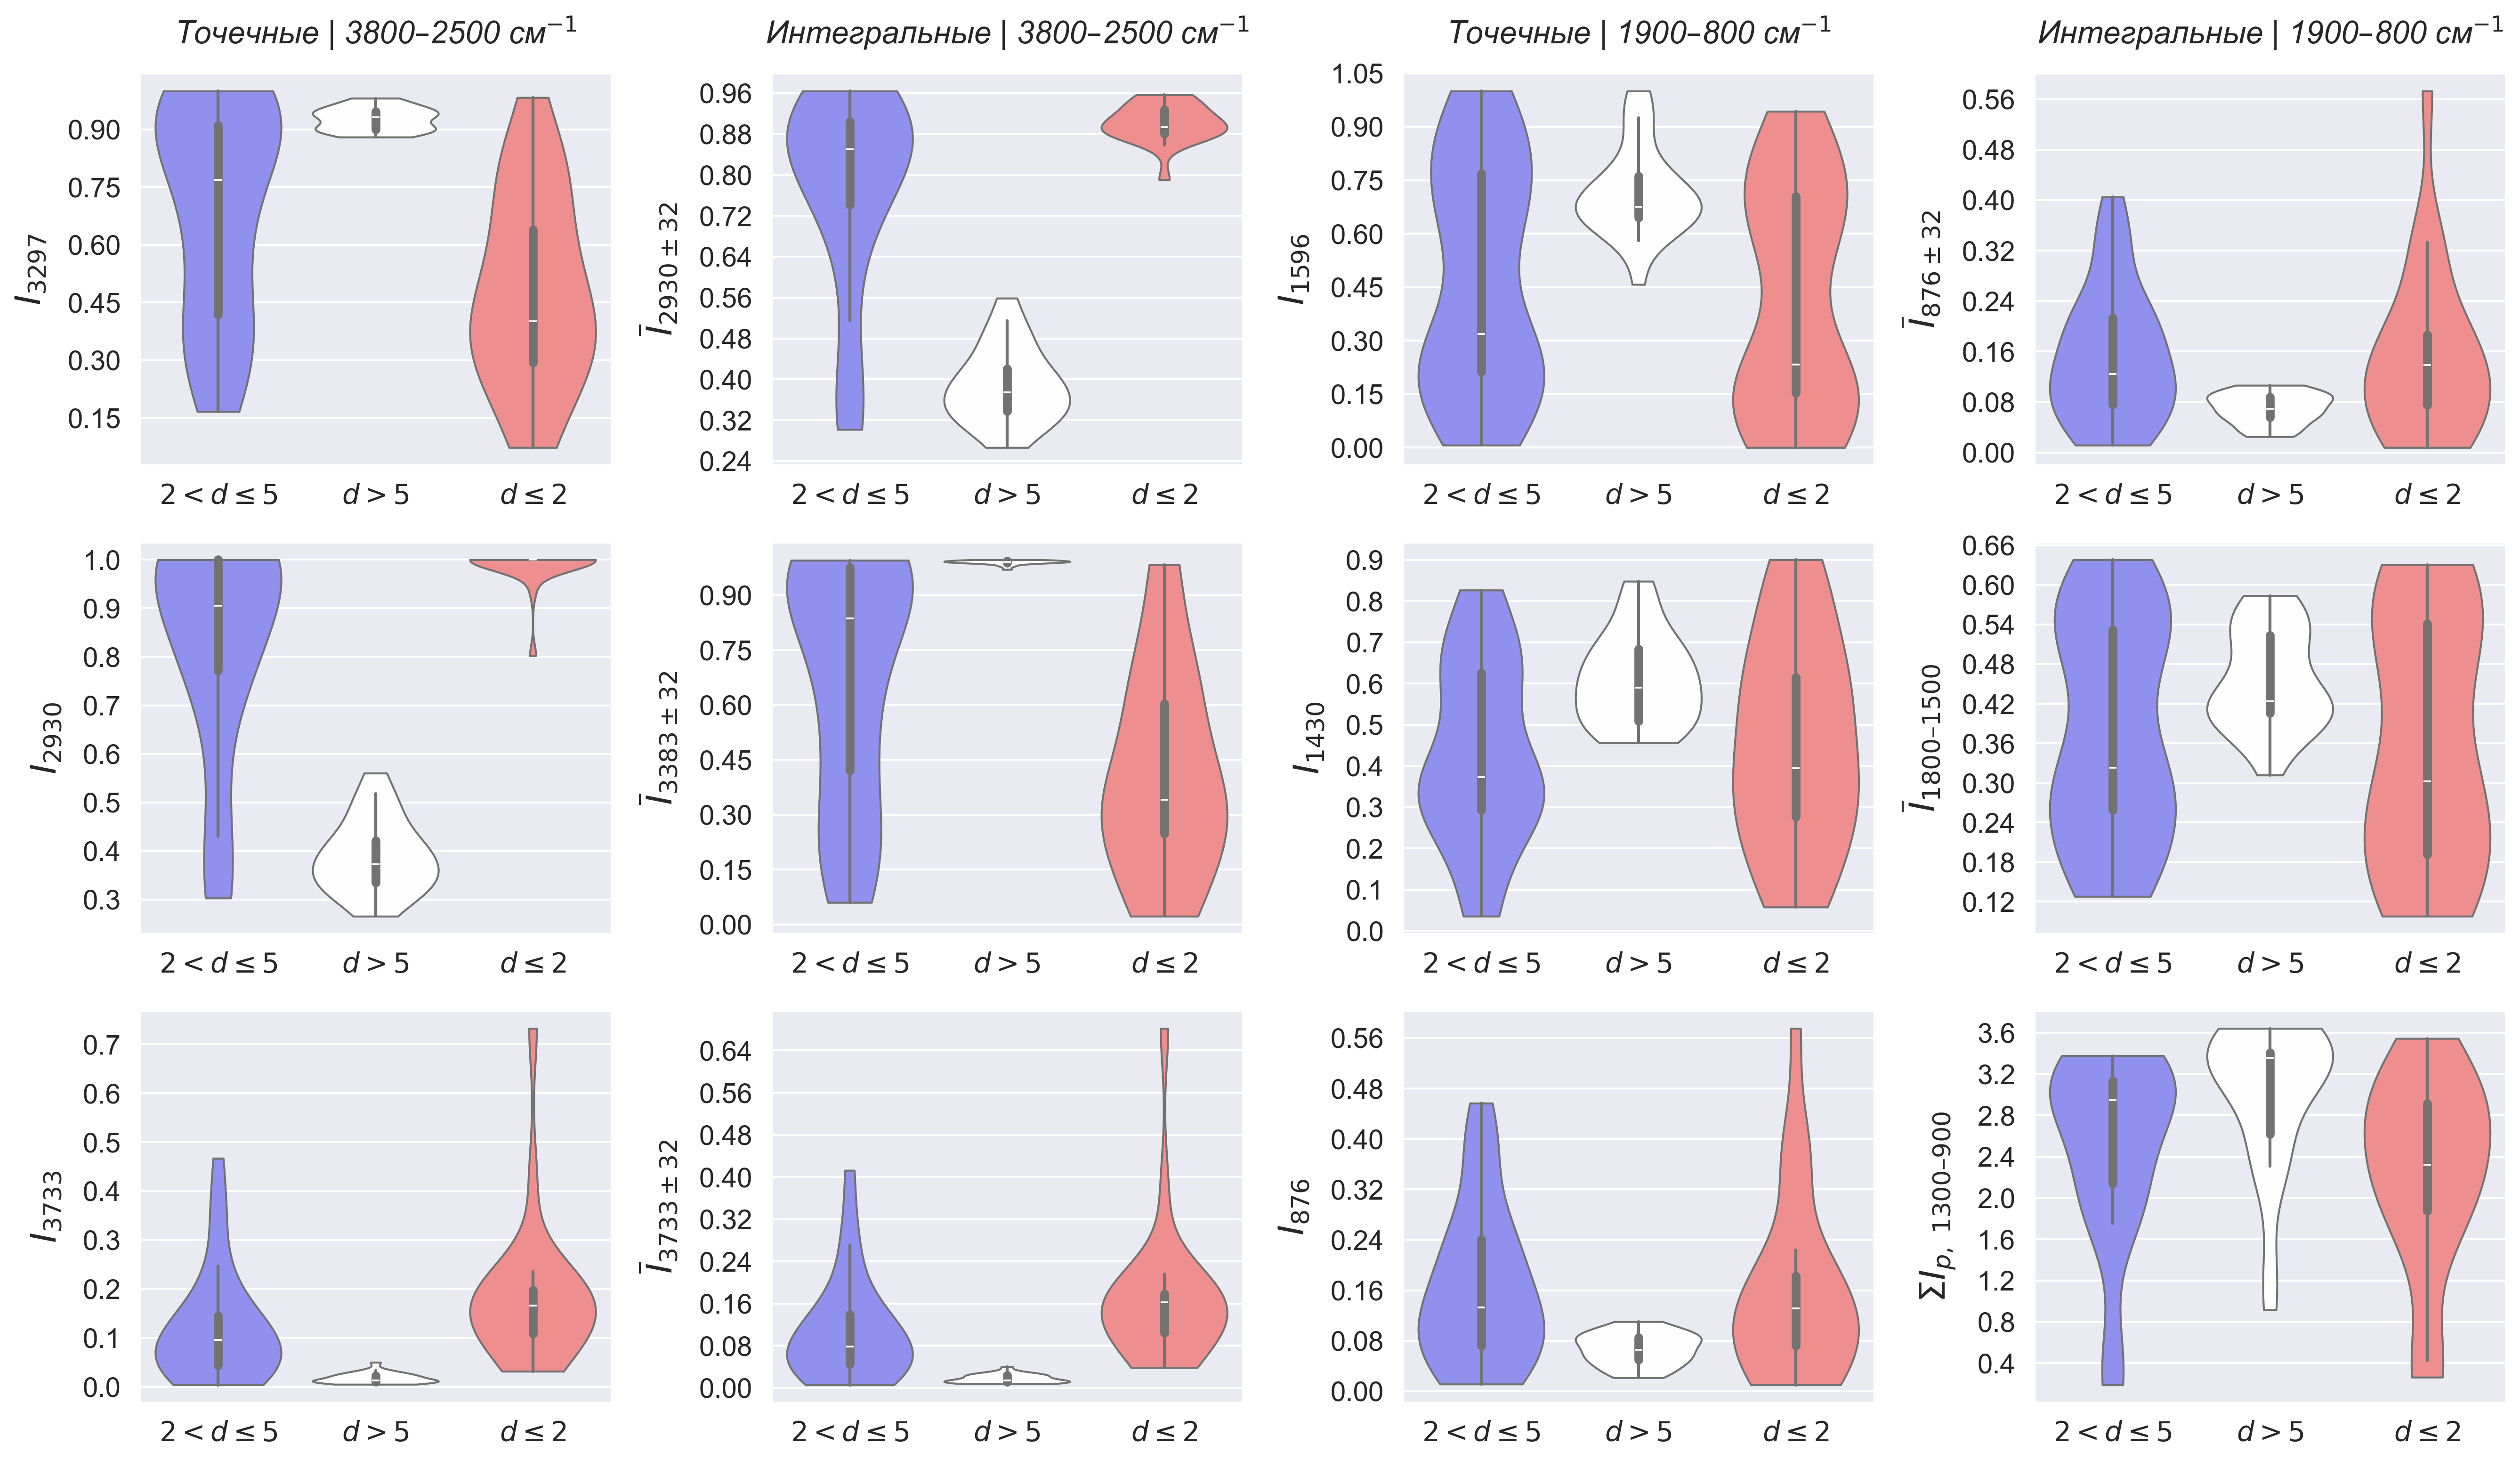

In [25]:
ncols = len(grouped_features)
nrows = 3

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4.5, nrows * 3.5), dpi=300)
axes = axes.T.flatten()

for col_idx, (feature_type, features) in enumerate(grouped_features.items()):
    for row_idx, feature in enumerate(features):
        ax = axes[col_idx * 3 + row_idx]

        sns.violinplot(
            data=df_vis,
            x='hue',
            y=feature,
            palette=PLOT_STYLE['PALETTE'],
            cut=PLOT_STYLE['VIOLIN_CUT'],
            inner=PLOT_STYLE['VIOLIN_INNER'],
            linewidth=PLOT_STYLE['VIOLIN_LINEWIDTH'],
            order=hue_order,
            ax=ax
        )

        if row_idx == 0:
            key = '_'.join(feature_type.split('_')[2:])
            title = f'{TITLE_MAP.get(key, feature_type)}'
            ax.set_title(title,
                         fontsize=PLOT_STYLE['TITLE_FONT_SIZE'],
                         fontstyle=PLOT_STYLE['TITLE_FONTSTYLE'],
                         pad=15)

        ax.set_xlabel('')
        ax.set_ylabel(
            feature,
            fontsize=PLOT_STYLE['Y_LABEL_FONT_SIZE'],
            labelpad=PLOT_STYLE['Y_LABELPAD']
        )

        ax.tick_params(axis='x', labelsize=PLOT_STYLE['X_TICK_LABEL_FONT_SIZE'])
        ax.tick_params(axis='y', labelsize=PLOT_STYLE['Y_TICK_LABEL_FONT_SIZE'])
        ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=PLOT_STYLE['X_NBINS']))

plt.tight_layout()

plt.savefig(f'{path_to_save}/violinplot_base_features.png', dpi=600)

plt.show()

### *Engineered* features

#### Ranking features

In [26]:
ranked_data = get_ranked_features_by_mutual_info(
    features_df=features_df,
    target=target,
    features_description=features_description,
    feature_types=engineered_feature_types
)

print(ranked_data.shape)
ranked_data.head(3)

(525, 3)


Feature  Mutual_Info  \
0              $\log I_{2930}$     0.604179   
1            $(I_{2930})^{-1}$     0.548121   
2  $\frac{I_{3733}}{I_{3297}}$     0.532652   

                          Feature_Type  
0  engineered_features_peaks_3800_2500  
1  engineered_features_peaks_3800_2500  
2  engineered_features_peaks_3800_2500

In [27]:
top_n = 3

top_features_df = ranked_data.groupby('Feature_Type').head(top_n)

print(top_features_df.shape)
top_features_df.head(3)

(12, 3)


Feature  Mutual_Info  \
0              $\log I_{2930}$     0.604179   
1            $(I_{2930})^{-1}$     0.548121   
2  $\frac{I_{3733}}{I_{3297}}$     0.532652   

                          Feature_Type  
0  engineered_features_peaks_3800_2500  
1  engineered_features_peaks_3800_2500  
2  engineered_features_peaks_3800_2500

In [28]:
top_features = top_features_df['Feature']

#### Data preparation

In [29]:
df_vis = features_df[top_features].copy()
df_vis['target'] = target
df_vis['hue'] = hue

print(df_vis.shape)
df_vis.head(3)

(75, 14)


$\log I_{2930}$  $(I_{2930})^{-1}$  \
division_1_size_bulk        -1.325672           3.764716   
division_1_size_5           -1.146384           3.146794   
division_1_size_3           -0.843399           2.324253   

                      $\frac{I_{3733}}{I_{3297}}$  \
division_1_size_bulk                     0.053325   
division_1_size_5                        0.007064   
division_1_size_3                        0.045526   

                      $\frac{\overline{I}_{3800\text{–}2500}}{\overline{I}_{3733 \pm 32}}$  \
division_1_size_bulk                                                              9.782377   
division_1_size_5                                                                75.716161   
division_1_size_3                                                                13.602428   

                      $\frac{\overline{I}_{3383 \pm 32}}{\overline{I}_{2930 \pm 32}}$  \
division_1_size_bulk                                                         3.643015   
division_1_size_5                                                            3.197332   
division_1_size_3                                                            2.419763   

                      $\frac{I_{3383}}{\overline{I}_{2930 \pm 32}}$  \
division_1_size_bulk                                       3.753476   
division_1_size_5                                          3.211491   
division_1_size_3                                          2.464242   

                      $\frac{I_{1724}}{I_{1243}}$  \
division_1_size_bulk                     0.787446   
division_1_size_5                        0.834959   
division_1_size_3                        0.803845   

                      $\frac{I_{1596}}{I_{1243}}$  \
division_1_size_bulk                     1.624590   
division_1_size_5                        1.721813   
division_1_size_3                        1.923209   

                      $\frac{I_{1430}}{I_{1391}}$  \
division_1_size_bulk                     0.830672   
division_1_size_5                        0.840227   
division_1_size_3                        0.871275   

                      $\frac{\overline{I}_{1544 \pm 32}}{\overline{I}_{1243 \pm 32}}$  \
division_1_size_bulk                                                         0.871882   
division_1_size_5                                                            0.845327   
division_1_size_3                                                            1.147453   

                      $\frac{\overline{I}_{1544 \pm 32}}{I_{1243}}$  \
division_1_size_bulk                                       0.856813   
division_1_size_5                                          0.837850   
division_1_size_3                                          1.147466   

                      $\frac{\overline{I}_{1300\text{–}900}}{\overline{I}_{1182 \pm 32}}$  \
division_1_size_bulk                                                             1.049131   
division_1_size_5                                                                0.877294   
division_1_size_3                                                                0.910436   

                      target             hue  
division_1_size_bulk       2         $d > 5$  
division_1_size_5          1  $2 < d \leq 5$  
division_1_size_3          1  $2 < d \leq 5$

In [30]:
feature_type_by_feature = dict(zip(ranked_data['Feature'], ranked_data['Feature_Type']))

grouped_features = defaultdict(list)

for feature in df_vis.columns:
    if feature in ['target', 'hue']:
        continue
    
    feature_type = feature_type_by_feature[feature]
    grouped_features[feature_type].append(feature)

#### Box plot

In [31]:
PLOT_STYLE = {
    'TITLE_FONT_SIZE': 16,
    'TITLE_FONTSTYLE': 'italic',
    'X_LABEL_FONT_SIZE': 16,
    'Y_LABEL_FONT_SIZE': 18,
    'X_TICK_LABEL_FONT_SIZE': 14,
    'Y_TICK_LABEL_FONT_SIZE': 14,
    'X_LABELPAD': 10,
    'Y_LABELPAD': 10,
    'X_NBINS': 10,
    'BOX_WIDTH': 0.6,
    'STRIP_ALPHA': 0.7,
    'STRIP_SIZE': 8,
    'STRIP_LINEWIDTH': 0.5,
    'STRIP_DODGE': True
}

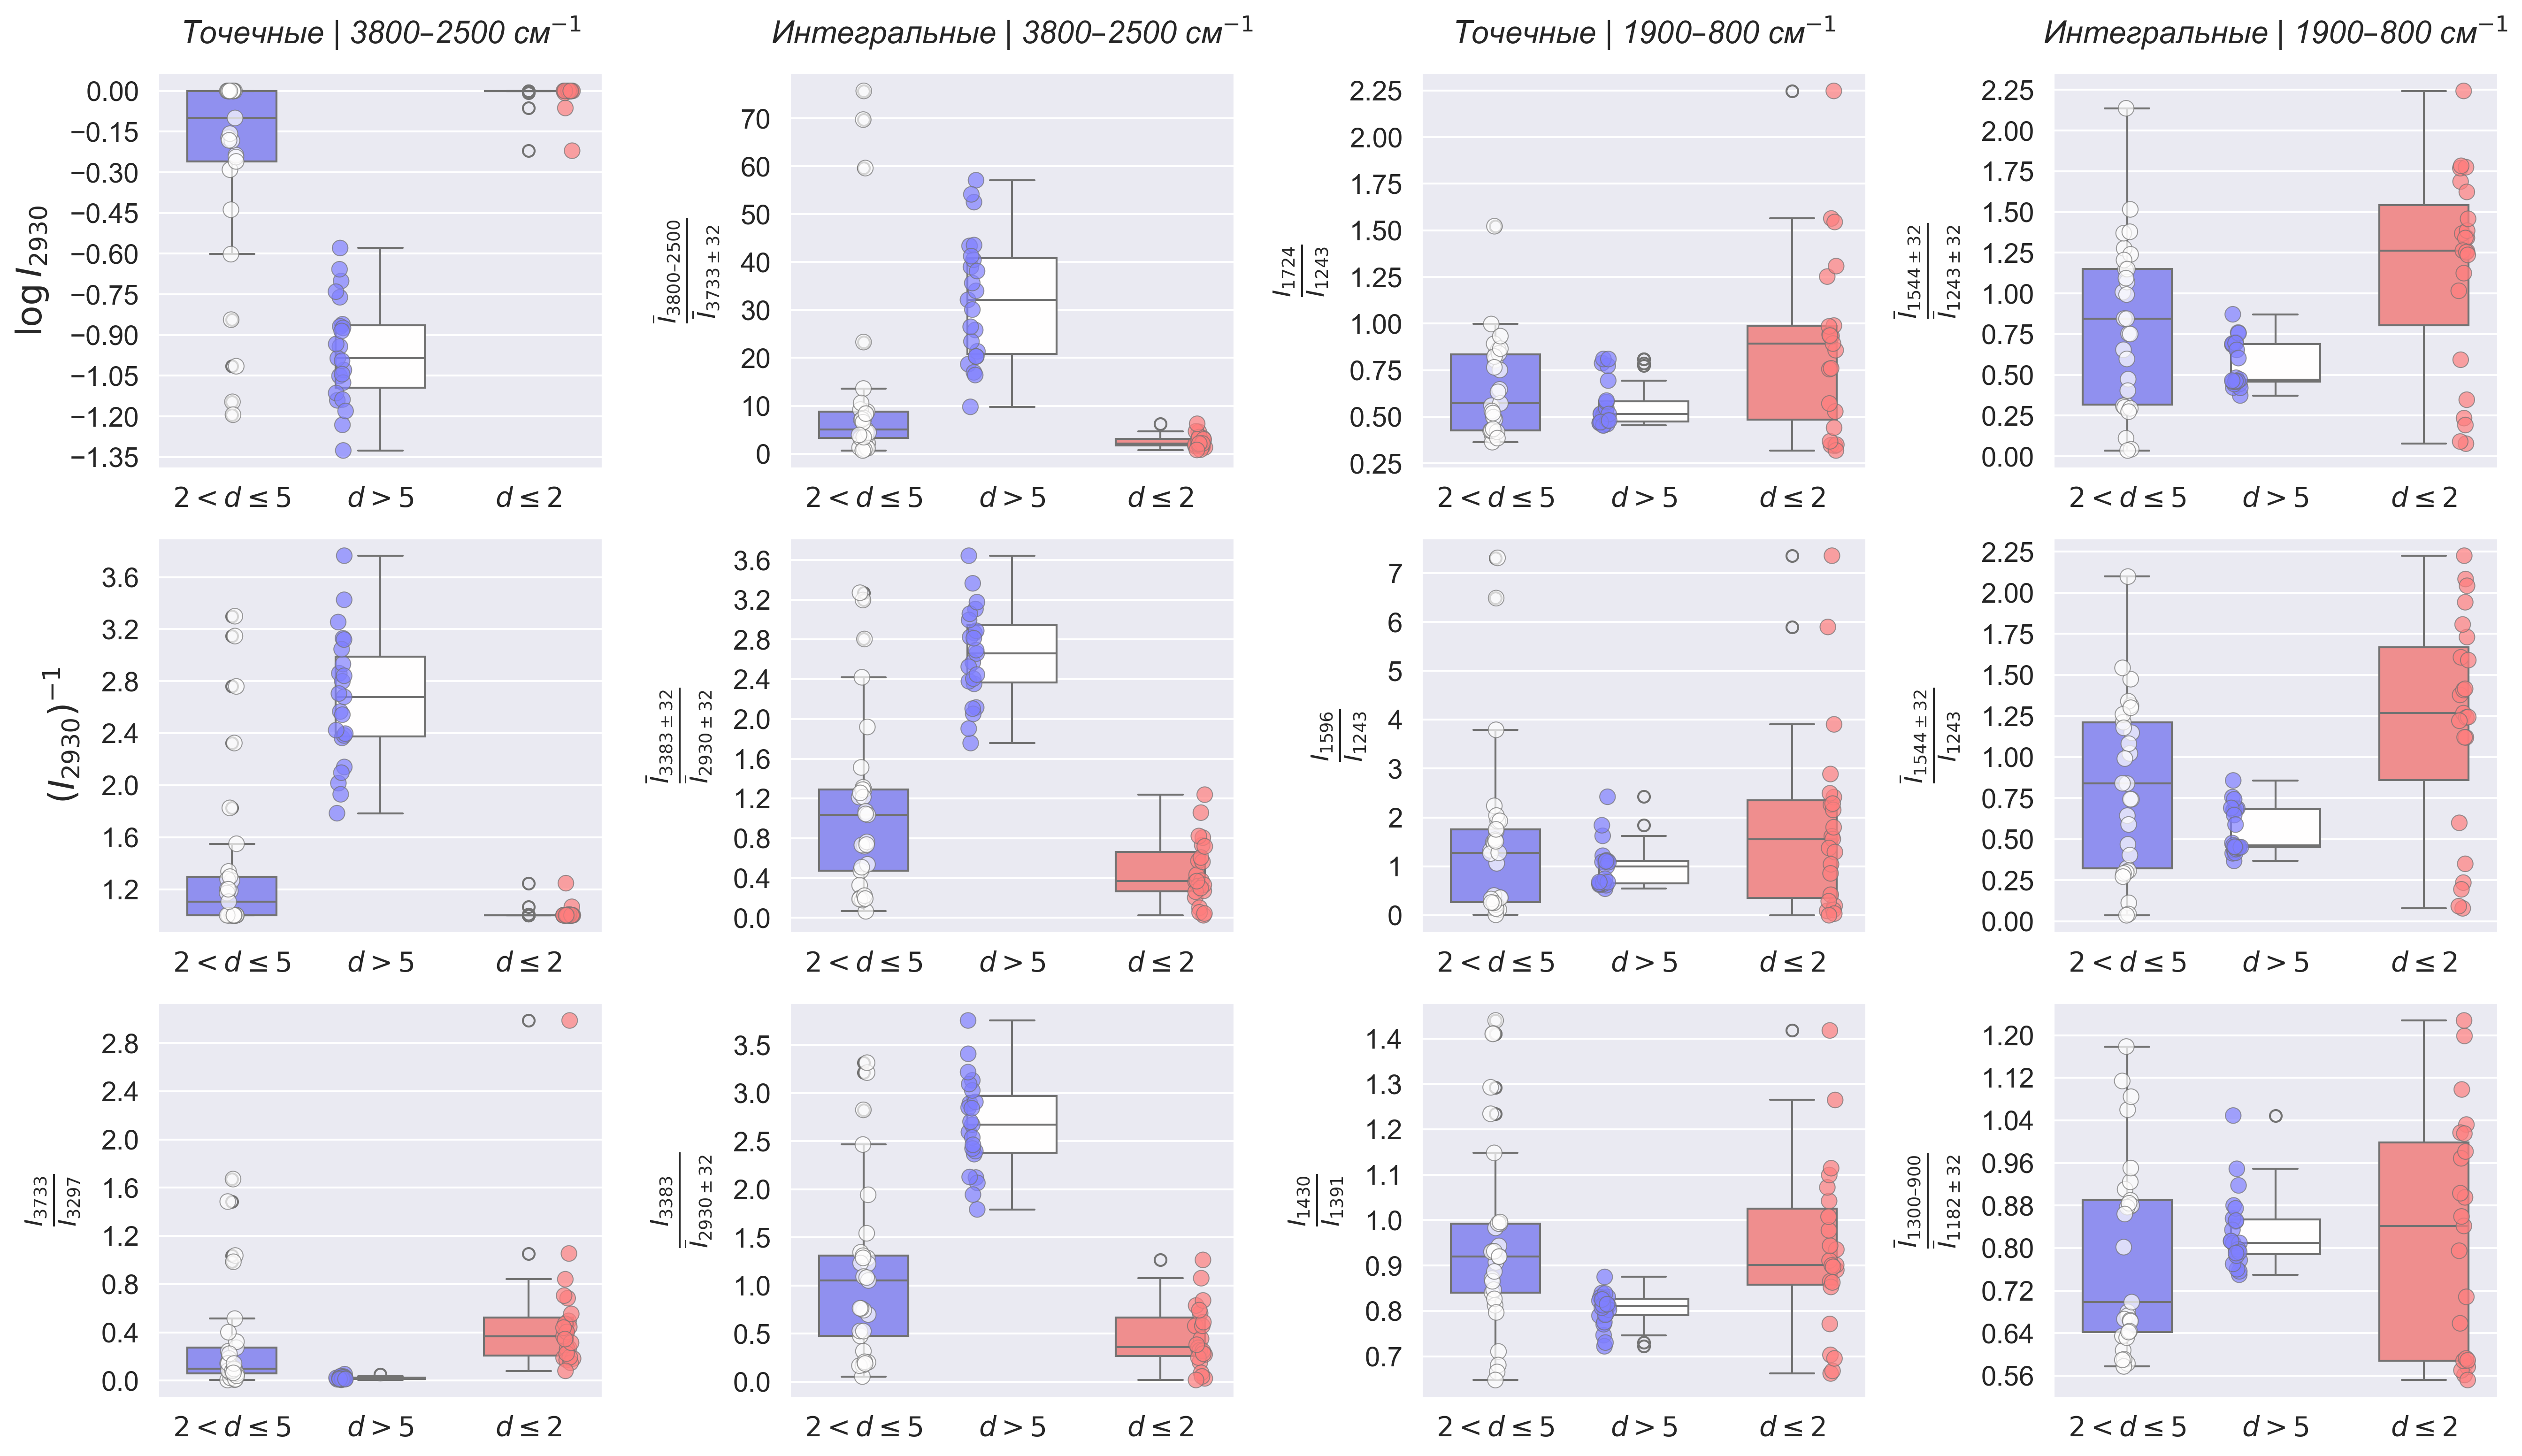

In [32]:
ncols = len(grouped_features)
nrows = 3

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4.5, nrows * 3.5), dpi=300)
axes = axes.T.flatten()

for col_idx, (feature_type, features) in enumerate(grouped_features.items()):
    for row_idx, feature in enumerate(features):
        ax = axes[col_idx * 3 + row_idx]

        sns.boxplot(
            data=df_vis,
            x='hue',
            y=feature,
            palette='bwr',
            width=PLOT_STYLE['BOX_WIDTH'],
            order=hue_order,
            ax=ax
        )

        sns.stripplot(
            data=df_vis,
            x='hue',
            y=feature,
            hue='hue',
            palette='bwr',
            alpha=PLOT_STYLE['STRIP_ALPHA'],
            size=PLOT_STYLE['STRIP_SIZE'],
            linewidth=PLOT_STYLE['STRIP_LINEWIDTH'],
            dodge=PLOT_STYLE['STRIP_DODGE'],
            ax=ax,
            legend=False
        )

        if row_idx == 0:
            key = '_'.join(feature_type.split('_')[2:])
            title = f'{TITLE_MAP.get(key, feature_type)}'
            ax.set_title(title, fontsize=PLOT_STYLE['TITLE_FONT_SIZE'], fontstyle=PLOT_STYLE['TITLE_FONTSTYLE'], pad=15)

        ax.set_xlabel('')
        ax.set_ylabel(feature, fontsize=PLOT_STYLE['Y_LABEL_FONT_SIZE'], labelpad=PLOT_STYLE['Y_LABELPAD'])

        ax.tick_params(axis='x', labelsize=PLOT_STYLE['X_TICK_LABEL_FONT_SIZE'])
        ax.tick_params(axis='y', labelsize=PLOT_STYLE['Y_TICK_LABEL_FONT_SIZE'])

        ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=PLOT_STYLE['X_NBINS']))

plt.tight_layout()

plt.savefig(f'{path_to_save}/boxplot_engineered_features.png', dpi=600)

plt.show()

#### Violin plot

In [33]:
PLOT_STYLE = {
    'TITLE_FONT_SIZE': 16,
    'TITLE_FONTSTYLE': 'italic',
    'X_LABEL_FONT_SIZE': 16,
    'Y_LABEL_FONT_SIZE': 18,
    'X_TICK_LABEL_FONT_SIZE': 14,
    'Y_TICK_LABEL_FONT_SIZE': 14,
    'X_LABELPAD': 10,
    'Y_LABELPAD': 10,
    'X_NBINS': 10,
    'VIOLIN_INNER': 'box',     # 'box', 'quartile', 'point', None
    'VIOLIN_CUT': 0,
    'VIOLIN_LINEWIDTH': 1,
    'PALETTE': 'bwr',
}


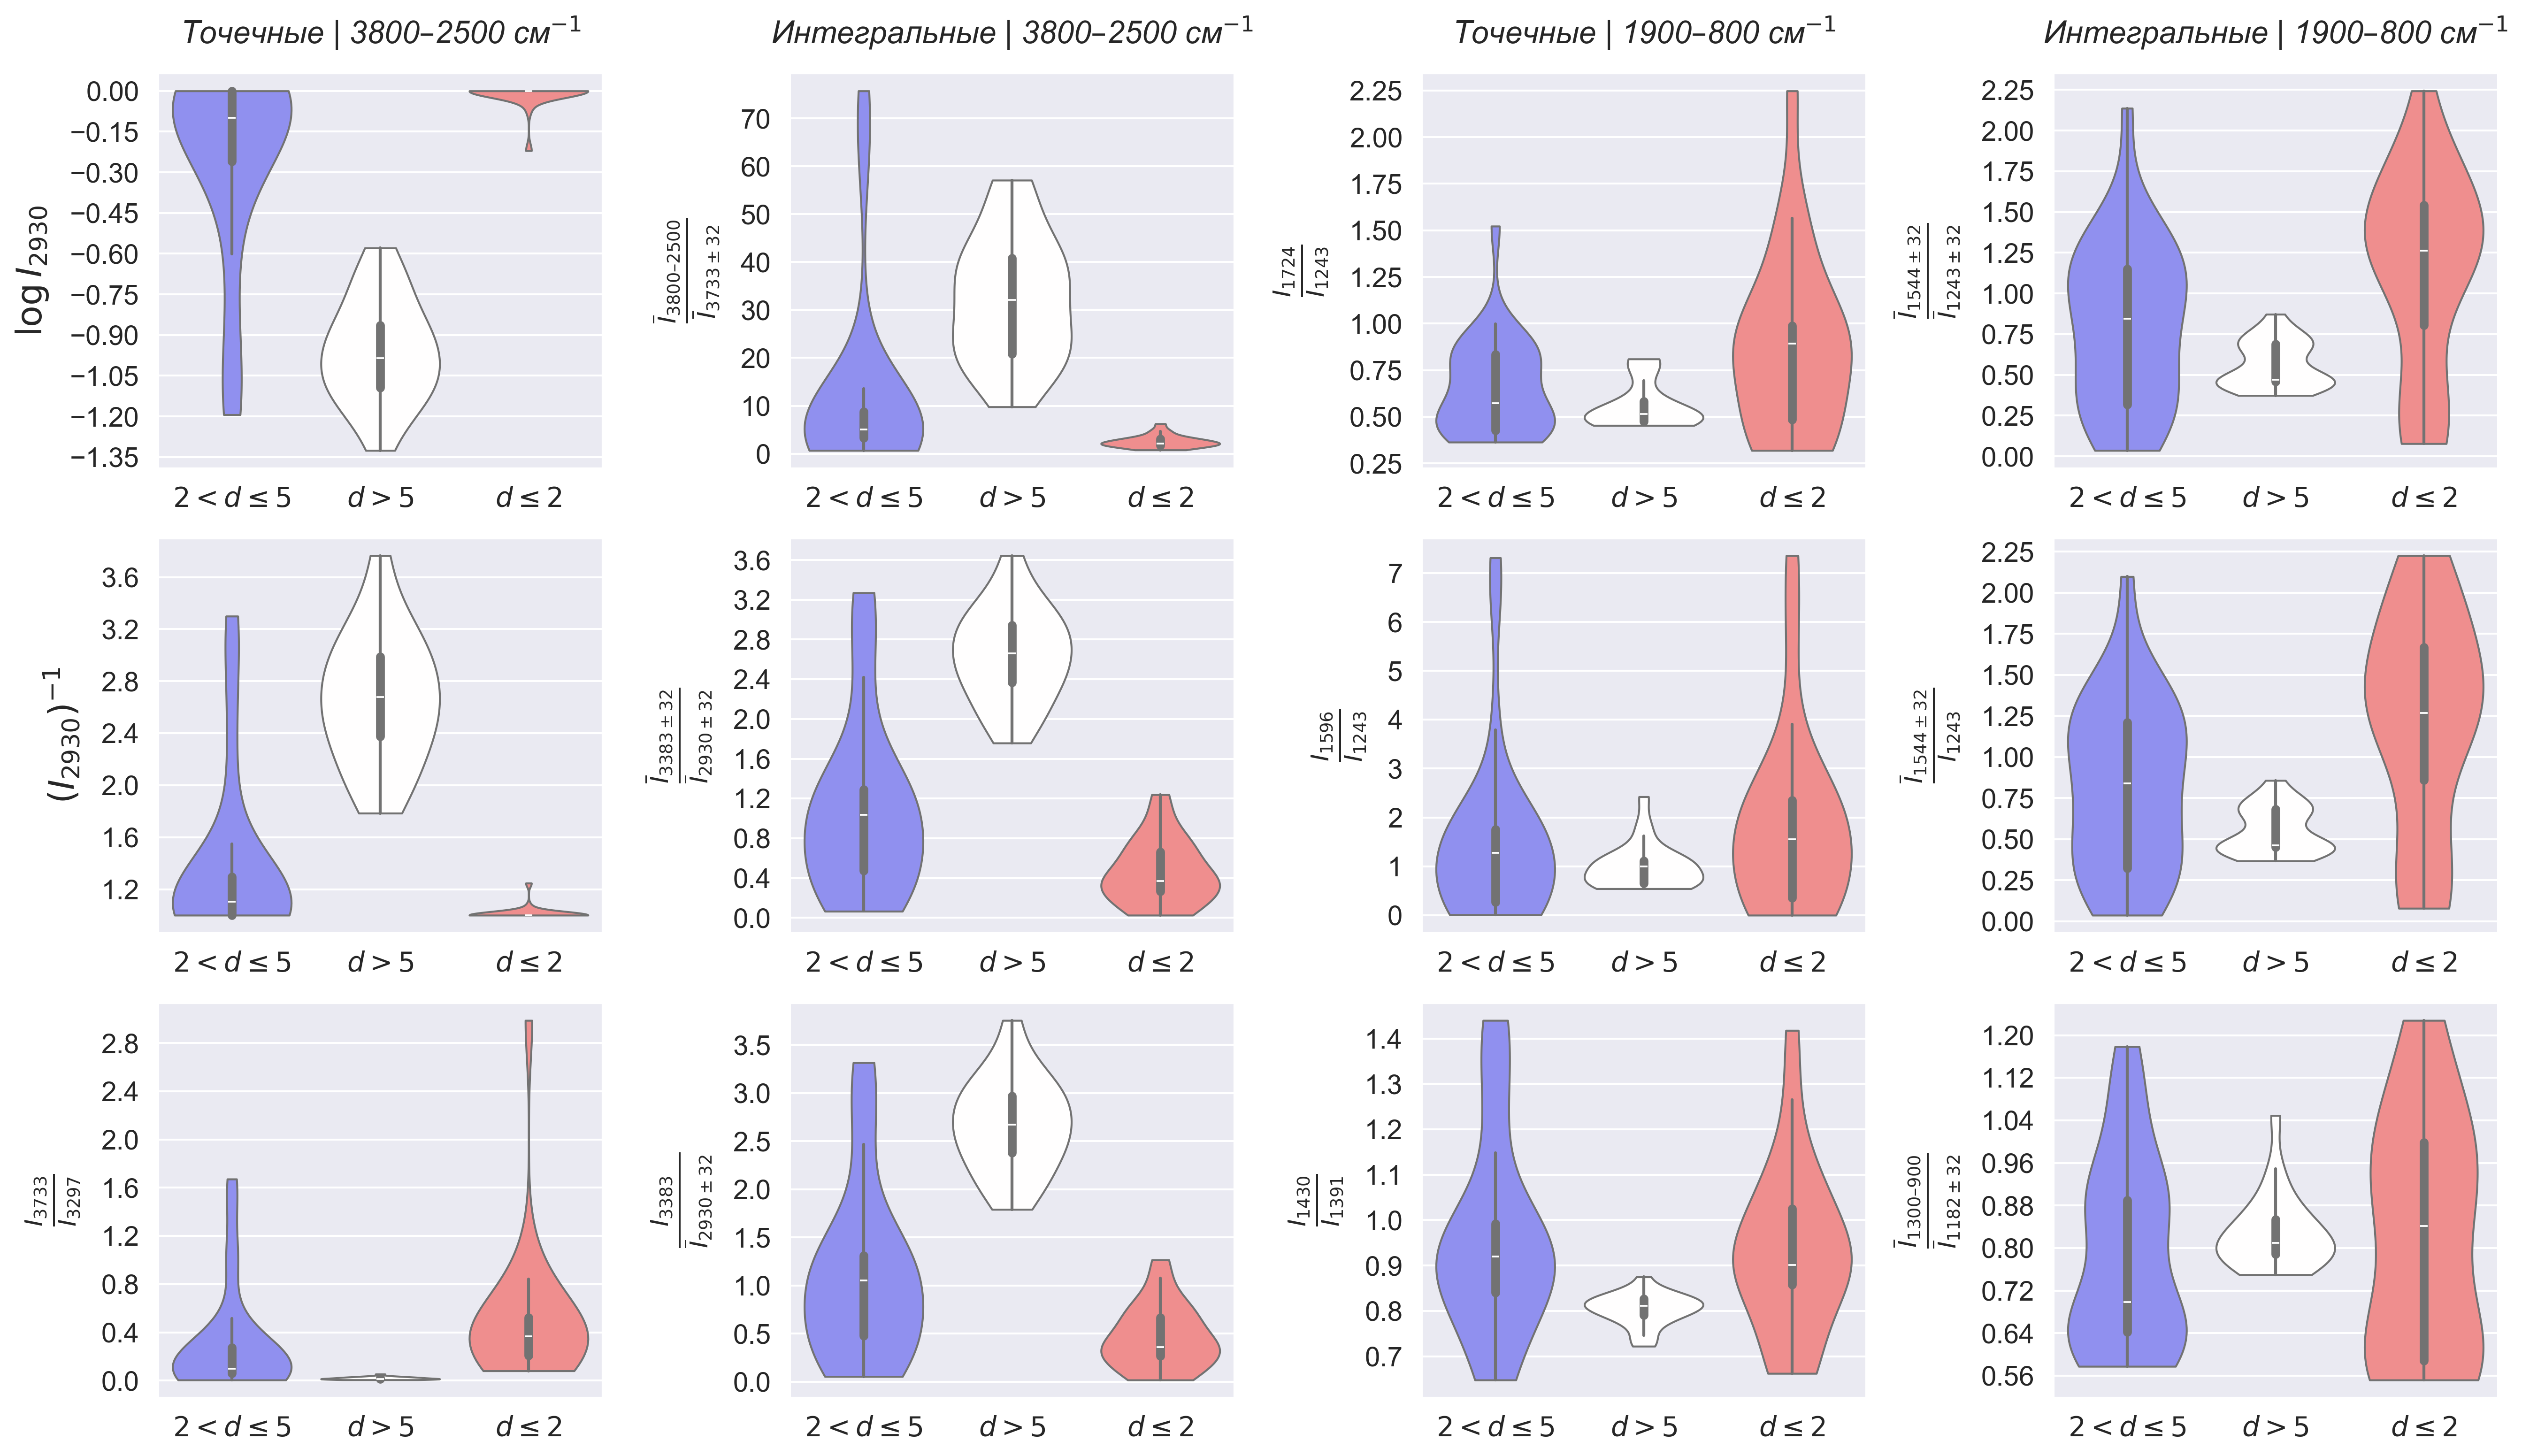

In [34]:
ncols = len(grouped_features)
nrows = 3

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4.5, nrows * 3.5), dpi=300)
axes = axes.T.flatten()

for col_idx, (feature_type, features) in enumerate(grouped_features.items()):
    for row_idx, feature in enumerate(features):
        ax = axes[col_idx * 3 + row_idx]

        sns.violinplot(
            data=df_vis,
            x='hue',
            y=feature,
            palette=PLOT_STYLE['PALETTE'],
            cut=PLOT_STYLE['VIOLIN_CUT'],
            inner=PLOT_STYLE['VIOLIN_INNER'],
            linewidth=PLOT_STYLE['VIOLIN_LINEWIDTH'],
            order=hue_order,
            ax=ax
        )

        if row_idx == 0:
            key = '_'.join(feature_type.split('_')[2:])
            title = f'{TITLE_MAP.get(key, feature_type)}'
            ax.set_title(title,
                         fontsize=PLOT_STYLE['TITLE_FONT_SIZE'],
                         fontstyle=PLOT_STYLE['TITLE_FONTSTYLE'],
                         pad=15)

        ax.set_xlabel('')
        ax.set_ylabel(
            feature,
            fontsize=PLOT_STYLE['Y_LABEL_FONT_SIZE'],
            labelpad=PLOT_STYLE['Y_LABELPAD']
        )

        ax.tick_params(axis='x', labelsize=PLOT_STYLE['X_TICK_LABEL_FONT_SIZE'])
        ax.tick_params(axis='y', labelsize=PLOT_STYLE['Y_TICK_LABEL_FONT_SIZE'])
        ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=PLOT_STYLE['X_NBINS']))

plt.tight_layout()

plt.savefig(f'{path_to_save}/violinplot_engineered_features.png', dpi=600)

plt.show()